In [ ]:
%cd cd /content/drive/MyDrive/Sound
!git clone https://github.com/seth814/Audio-Classification.git
!pip install python_speech_features

[Errno 2] No such file or directory: 'cd /content/drive/MyDrive/Sound'
/content
Cloning into 'Audio-Classification'...
remote: Enumerating objects: 534, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 534 (delta 26), reused 21 (delta 7), pack-reused 478
Receiving objects: 100% (534/534), 100.03 MiB | 25.05 MiB/s, done.
Resolving deltas: 100% (106/106), done.
Checking out files: 100% (325/325), done.
  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5888 sha256=d1dbf3b486c183e7737204f9b2c1c3d13f41b4b91083a7ab46b85a1ab360810e
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python-speech-features


In [ ]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
!pip install python_speech_features
from python_speech_features import mfcc, logfbank
import librosa

%cd /content/drive/MyDrive/Sound/Nature

  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5888 sha256=0d85f32f25dd2c53b0bdf6dab01337d7cf1f38e739754602b2d2c98b569cd43e
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python-speech-features
/content/drive/MyDrive/Sound/Nature


In [ ]:
def plot_signals(signals):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Time Series', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_fft(fft):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Fourier Transforms', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            data = list(fft.values())[i]
            Y, freq = data[0], data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq, Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_fbank(fbank):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

#create signal envelope so we filter out low amplitude/noise
#Ref: https://www.youtube.com/watch?v=mUXkj1BKYk0
def envelope(y, rate, threshold):
    mask = []
    #we want a rolling window so we create series as it is easy with it
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10), min_periods=1, center=True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
            
    return mask
    
def calc_fft(y, rate):
    n = len(y)
    freq = np.fft.rfftfreq(n, d=1/rate)
    Y = abs(np.fft.rfft(y)/n)
    
    return (Y, freq)

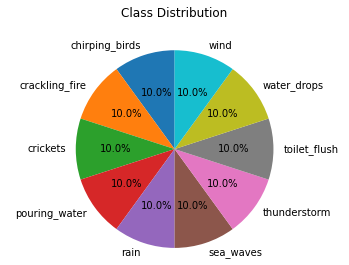

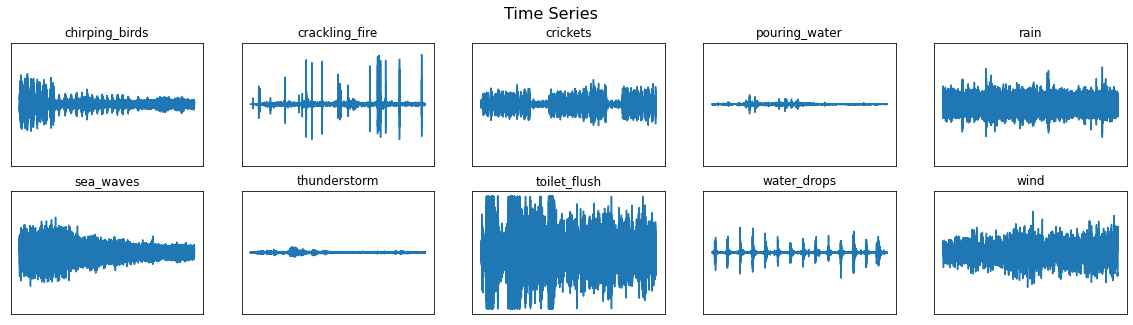

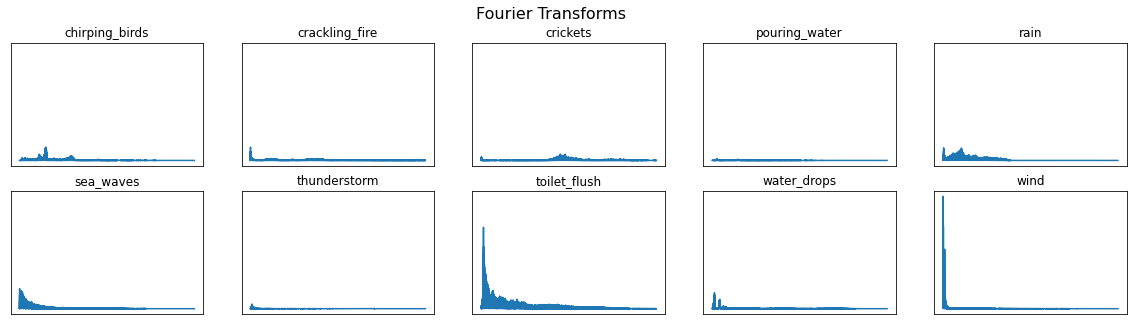

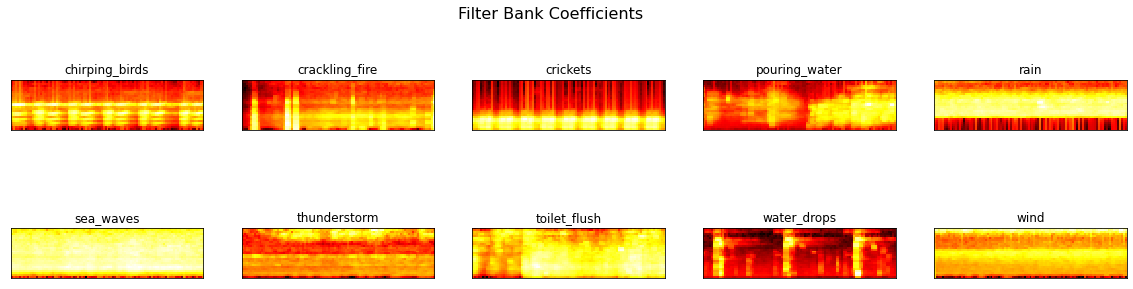

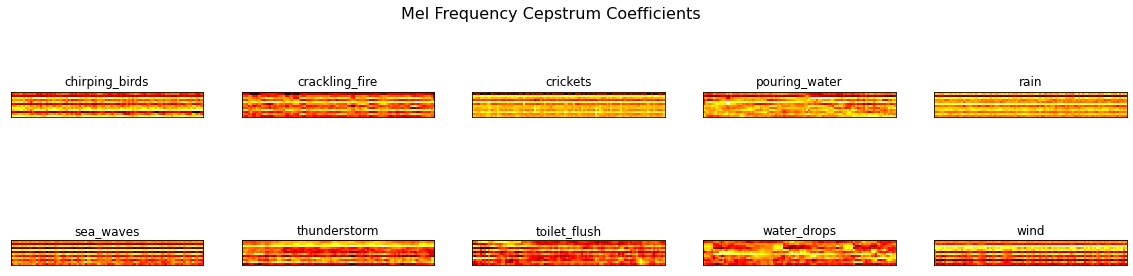

100%|██████████| 400/400 [01:36<00:00,  4.14it/s]


In [ ]:
df = pd.read_csv('meta.csv')
df.set_index('fname',inplace=True)

for f in df.index:
    rate, signal = wavfile.read('wavfiles/' + f)
    df.at[f, 'length'] = signal.shape[0]/rate

classes = list(np.unique(df.category))
class_dist = df.groupby(['category'])['length'].mean()

fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()
df.reset_index(inplace=True)

signals = {}
fft = {}
fbank = {}
mfccs = {}

for c in classes:
    wav_file = df[df.category == c].iloc[0,0]
    signal, rate = librosa.load('wavfiles/'+wav_file,sr=44100)
    mask = envelope(signal, rate, 0.0005) #0.0005 is experimental
    signal = signal[mask]
    signals[c] = signal
    fft[c] = calc_fft(signal, rate)
    
    bank = logfbank(signal[:rate], rate, nfilt=26, nfft=1103).T
    fbank[c] = bank
    mel = mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=1103).T
    mfccs[c] = mel
    
plot_signals(signals)
plt.show()

plot_fft(fft)
plt.show()

plot_fbank(fbank)
plt.show()

plot_mfccs(mfccs)
plt.show()

if len(os.listdir('clean')) == 0:
    for f in tqdm(df.fname):
        signal, rate = librosa.load('wavfiles/'+f, sr=16000) 
        wavfile.write(filename='clean/'+f, rate=rate, data=signal)

In [1]:
# Flexible code to resume model training if that already exists
%cd /content/drive/MyDrive/Sound/Nature
import os 
from scipy.io import wavfile 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt 
import numpy as np 
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM 
from keras.layers import Dropout, Dense, TimeDistributed 
from keras.models import Sequential 
from tensorflow.keras.utils import to_categorical 
from sklearn.utils.class_weight import compute_class_weight 
from tqdm import tqdm 
!pip install python_speech_features 
from python_speech_features import mfcc 
import os
import pickle
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from cfg import Config

# class Config:
#     def __init__(self, mode='conv', nfilt=26, nfeat=13, nfft=512, rate=16000):
#         self.mode = mode
#         self.nfilt = nfilt
#         self.nfft = nfft
#         self.nfeat = nfeat
#         self.rate = rate
#         self.step = int(rate/10)
#         self.model_path = os.path.join('./models',mode  +'.model')
#         self.p_path = os.path.join('./pickles', mode + '.pkl') 

def check_data():
  if os.path.isfile(config.p_path):
    print("Loading existing data for {} model".format(config.mode)) 
    with open(config.p_path,'rb') as handle:
        tmp = pickle.load(handle) 
        return tmp
  else:
    return None        

def build_rand_feat():
    tmp = check_data()
    if tmp:
      return tmp.data[0],tmp.data[1] 
    X = []
    y = []
    #float('inf) is a kind of infinite integer variable generaly assigned for possibly very numbers
    _min, _max = float('inf'), -float('inf') 
    for _ in tqdm(range(n_samples)): # iterate over all samples generated
        # pick a randon class based on probability density
        rand_class = np.random.choice(class_dist.index, p=prob_dist)
        # Pick a random file based on class selected
        file = np.random.choice(df[df.category == rand_class].index)  
        # Read the file
        rate, wav = wavfile.read('clean/'+file)
        category = df.at[file, 'category'] 
        # print("***************")
        # print(file)
        # print(0, wav.shape[0])
        # print(0, wav.shape[0]-config.step)
        # print("*********************")
        # To make it more robust, pick a random index sample from the file selected
        rand_index = np.random.randint(0, wav.shape[0]-config.step)
        # Retrieve the indexed sample from the 'wav' that is the signal data of selected file
        sample = wav[rand_index:rand_index + config.step]  
        # Generate the mfcc of the random sample picked
        X_sample = mfcc(sample, rate,numcep=config.nfeat, nfilt=config.nfilt,
                        nfft=config.nfft)
        _min = min(np.amin(X_sample), _min) 
        _max = max(np.amax(X_sample), _max) 
        X.append(X_sample) 
        y.append(classes.index(category)) 
    # store  min and max values all the mfccs features in config instance       
    config.min = _min
    config.max = _max
    X, y = np.array(X), np.array(y)
    # Normalize the X values based on min and max scale
    X = (X - _min) / (_max - _min)
    if config.mode == 'conv':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    elif config.mode == 'time':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
    y = to_categorical(y, num_classes = 10)
    config.data = (X,y)

    with open(config.p_path,'wb')as handle:
      pickle.dump(config,handle, protocol=2)
    return X, y

def get_conv_model():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', strides=(1, 1),
                     padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1),
                     padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', strides=(1, 1),
                     padding='same'))    
    model.add(Conv2D(128, (3, 3), activation='relu', strides=(1, 1),
                     padding='same'))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    # In the final dense layer we put the number of channels based on the number of classes
    model.add(Dense(10, activation='softmax'))
    model.summary()
    opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
    model.compile(loss='categorical_crossentropy',
                  optimizer= 'Adam',
                  metrics=['acc'])
    return model

def get_recurrent_model():
    #shape of data for RNN is (n, time, feature)
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(64, activation='selu')))
    model.add(TimeDistributed(Dense(32, activation='selu')))
    model.add(TimeDistributed(Dense(16, activation='selu')))
    model.add(TimeDistributed(Dense(8, activation='selu')))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    model.summary()
    opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['acc'])
    return model

df = pd.read_csv('meta.csv')
df.set_index('fname', inplace=True)

for f in df.index:
    rate, signal = wavfile.read('/content/drive/MyDrive/Sound/Nature/clean/'+f)     # signal.shape[1] gives number of channels and shape[0] gives number of samples
    df.at[f,'length'] = signal.shape[0]/rate    # rate is about samples per second so length gives duration of signal stored in seconds

classes = list(np.unique(df.category)) 
class_dist = df.groupby(['category'])['length'].mean()    # individual mean of all classes length

n_samples = 2 * int(df['length'].sum()/0.1)     # Gives the one tenth of total length of all classes
prob_dist = class_dist / class_dist.sum()       # P[mean]/sum_of_P[mean] will give us probability distribution list
choices = np.random.choice(class_dist.index, p=prob_dist)  # generating choice category based on class distribution

config = Config(mode='conv')

if config.mode == 'conv':    
    # load the model if it has been constructed already
    print(config.model_path)
    if os.path.isdir(config.model_path):
      model = load_model(config.model_path)
      with open(config.p_path,'rb') as handle:
          config = pickle.load(handle)    
          X,y = config.data
          y_flat = np.argmax(y, axis=1)
          # assign number of extra epochs you want to train
          epochs =10
    else:  
      X, y = build_rand_feat()
      y_flat = np.argmax(y, axis=1)
      input_shape = (X.shape[1], X.shape[2], 1)
      model = get_conv_model()
      # initial epochs
      epochs =30
    
elif config.mode == 'time':
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1], X.shape[2])
    model = get_recurrent_model()
    
class_weight = compute_class_weight(class_weight = 'balanced',
                                    classes = np.unique(y_flat),
                                    y = y_flat)
checkpoint = ModelCheckpoint(config.model_path,monitor ='val_acc',verbose = 1,mode = 'max',
                            save_best_only = True, save_weights_only=False, period =1)
model.fit(X, y, epochs=epochs, batch_size=32,
          shuffle=True,validation_split = 0.1,
          callbacks = [checkpoint]) 
model.save(config.model_path) 


/content/drive/MyDrive/Sound/Nature
  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5888 sha256=f339689cf65f247607fbfb5f2ee6a81ef85520535530ea905616143e7cc99ffa
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python-speech-features
./models/conv.model
Epoch 1/10
1124/1125 [============================>.] - ETA: 0s - loss: 0.1082 - acc: 0.9634
Epoch 00001: val_acc improved from -inf to 0.95150, saving model to ./models/conv.model
INFO:tensorflow:Assets written to: ./models/conv.model/assets
1125/1125 [==============================] - 26s 14ms/step - loss: 0.1081 - acc: 0.9634 - val_loss: 0.1627 - val_acc: 0.9515
Epoch 2/10
1125/1125 [==============================] - ETA: 0s - loss: 0.1082 - acc: 0.9629
Epoch 00002: val_acc did not improve from 0.95150
1125/1125 [==============================] - 12s 10ms/step - loss: 0.1082 - acc: 0.9629 - val_loss: 0.177

In [ ]:
#prediction file, here we are predicit

import pickle
import os
import numpy as numpy
import pandas as pd
from tqdm import tqdm
from scipy.io import wavfile
!pip install python_speech_features
from python_speech_features import mfcc
from keras.models import load_model
from sklearn.metrics import accuracy_score
import numpy as np
%cd /content/drive/MyDrive/Sound/Nature

def build_predictions(audio_dir):
  y_true = []
  y_pred = []
  fn_prob = {}

  print('Extarcting features from audio')
  for fn in tqdm(os.listdir(audio_dir)):
    rate,wav = wavfile.read(os.path.join(audio_dir,fn))
    category = fn2class[fn]
    c = classes.index(category)
    y_prob = []

    for i in range(0,wav.shape[0]-config.step,config.step):
       sample = wav[i:i+config.step]
       x = mfcc(sample,rate,numcep = config.nfeat,
                nfilt = config.nfilt,nfft = config.nfft)
       x = (x-config.min)/(config.max-config.min)

       if config.mode =='conv':
         x= x.reshape(1,x.shape[0],x.shape[1],1)
       elif config.mode =='time':
         x = np.expand_dims(x,axis = 0)
       y_hat = model.predict(x)  
       y_prob.append(y_hat)
       y_pred.append(np.argmax(y_hat))
       y_true.append(c)

    fn_prob[fn] = np.mean(y_prob,axis = 0).flatten()
  return y_true, y_pred, fn_prob

# here  we are making a dictionary with fname as key and the values category
df = pd.read_csv('meta.csv')
classes = list(np.unique(df.category))
fn2class = dict(zip(df.fname,df.category))
p_path = './pickles/conv.pkl'

with open(p_path,'rb') as handle:
  config = pickle.load(handle)

model = load_model(config.model_path)

y_true,y_pred, fn_prob = build_predictions('valid')
acc_score = accuracy_score(y_true=y_true,y_pred = y_pred)

y_probs = []
for i,row in df.iterrows():
  y_prob = fn_prob[row.fname]
  y_probs.append(y_prob)
  for c,p in zip(classes,y_prob):
    df.at[i,c] = p

y_pred = [classes[np.argmax(y)] for y in y_probs]
df['y_pred'] = y_pred

df.to_csv('predictions.csv')


In [ ]:
#predicting single file from tested data

import pickle
import os
import numpy as numpy
import pandas as pd
from tqdm import tqdm
from scipy.io import wavfile
!pip install python_speech_features
from python_speech_features import mfcc
from keras.models import load_model
from sklearn.metrics import accuracy_score
from cfg import Config
import numpy as np
%cd /content/drive/MyDrive/Sound/Nature

p_path = './pickles/conv.pkl'

with open(p_path,'rb') as handle:
  config = pickle.load(handle)

model = load_model(config.model_path)

print('Extarcting features from audio')
test_file = '/content/drive/MyDrive/Sound/Nature/rain-testing.wav'
signal, rate = librosa.load(test_file, sr=16000) 
wavfile.write(filename='test_file_clean.wav', rate=rate, data=signal)
rate,wav = wavfile.read('test_file_clean.wav')

for i in range(0,wav.shape[0]-config.step,config.step):
    sample = wav[i:i+config.step]
    x = mfcc(sample,rate,numcep = config.nfeat,
            nfilt = config.nfilt,nfft = config.nfft)
    x = (x-config.min)/(config.max-config.min)
    x= x.reshape(1,x.shape[0],x.shape[1],1)
    y_hat = model.predict(x)  
    y_pred = np.argmax(y_hat)

# here  we are making a dictionary with fname as key and the values category
df = pd.read_csv('meta.csv')
classes = list(np.unique(df.category))

print(classes[y_pred])


/content/drive/MyDrive/Sound/Nature
Extarcting features from audio
rain


In [ ]:
# import the needed libraries
import tensorflow as tf
tf.keras.backend.set_learning_phase(0) #use this if we have batch norm layer in our network
from tensorflow.keras.models import load_model


# path we wanna save our converted TF-model
#MODEL_PATH = "./model/tensorflow/big/model1"
MODEL_PATH = '/content/drive/MyDrive/Sound/Nature/trtl'

# load the Keras model
#model = load_model('./model/modelLeNet5.h5')
model = load_model('/content/drive/MyDrive/Sound/Nature/conv.model')

# save the model to Tensorflow model
saver = tf.train.Saver()
sess = tf.keras.backend.get_session()
save_path = saver.save(sess, MODEL_PATH)

print("Keras model is successfully converted to TF model in "+MODEL_PATH) 

/usr/local/lib/python3.7/dist-packages/keras/backend.py:414: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


AttributeError: ignored